In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Competition and Data:
https://www.kaggle.com/competitions/titanic/overview/description 

# Setup

In [2]:
import os
import random

from scipy import stats
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def random_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
random_seeds(0)

In [4]:
train_path = "/kaggle/input/titanic/train.csv"
train_data = pd.read_csv(train_path)
test_path = "/kaggle/input/titanic/test.csv"
test_data = pd.read_csv(test_path)

eng_data = train_data.copy()

# Exploratory Data Analysis

In [5]:
# test_data doesn't contain labels, so it cannot actually be used as the test set.
pred_data = test_data
test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
null_cols = [col for col in train_data.columns if train_data[col].isnull().any()]

print(f'Numerical columns: {numerical_cols}')
print(f'Categorical columns: {categorical_cols}')
print(f'Columns with missing values: {null_cols}')

Numerical columns: ['Age', 'SibSp', 'Parch', 'Fare']
Categorical columns: ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Columns with missing values: ['Age', 'Cabin', 'Embarked']


## Histograms (Numerical Columns)

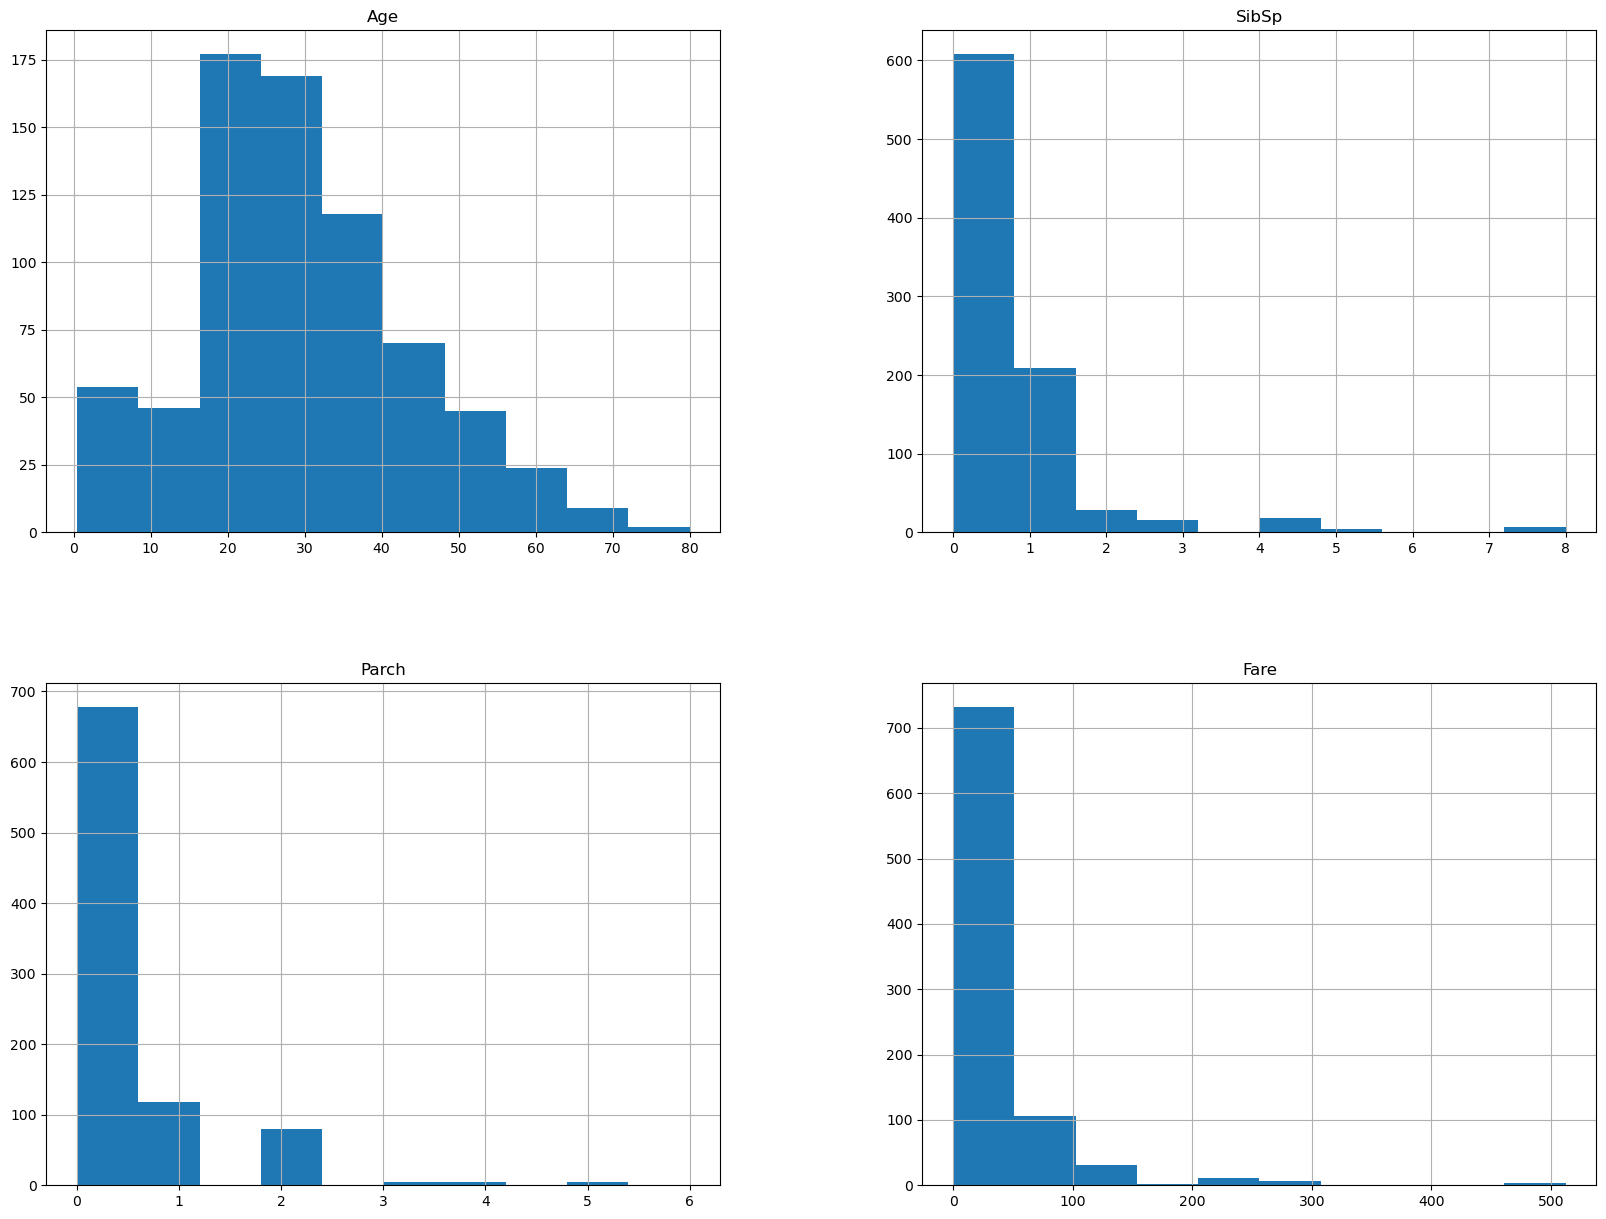

In [10]:
# fig, axs = plt.subplots(1, 2, sharey=True)
# train_data['Age'].plot(kind='hist')
train_data.hist(column=numerical_cols, figsize=(20, 15))
plt.show()

## Bar Plots (Categorical Columns)

<AxesSubplot:ylabel='Survived'>

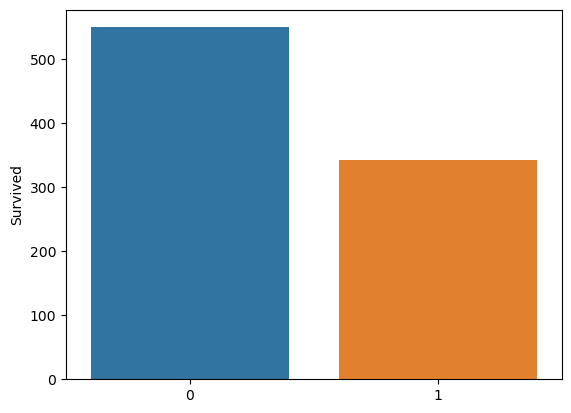

In [11]:
# train_data['Survived'].value_counts().plot(kind='bar')
sns.barplot(x=train_data['Survived'].value_counts().index, y=train_data['Survived'].value_counts())

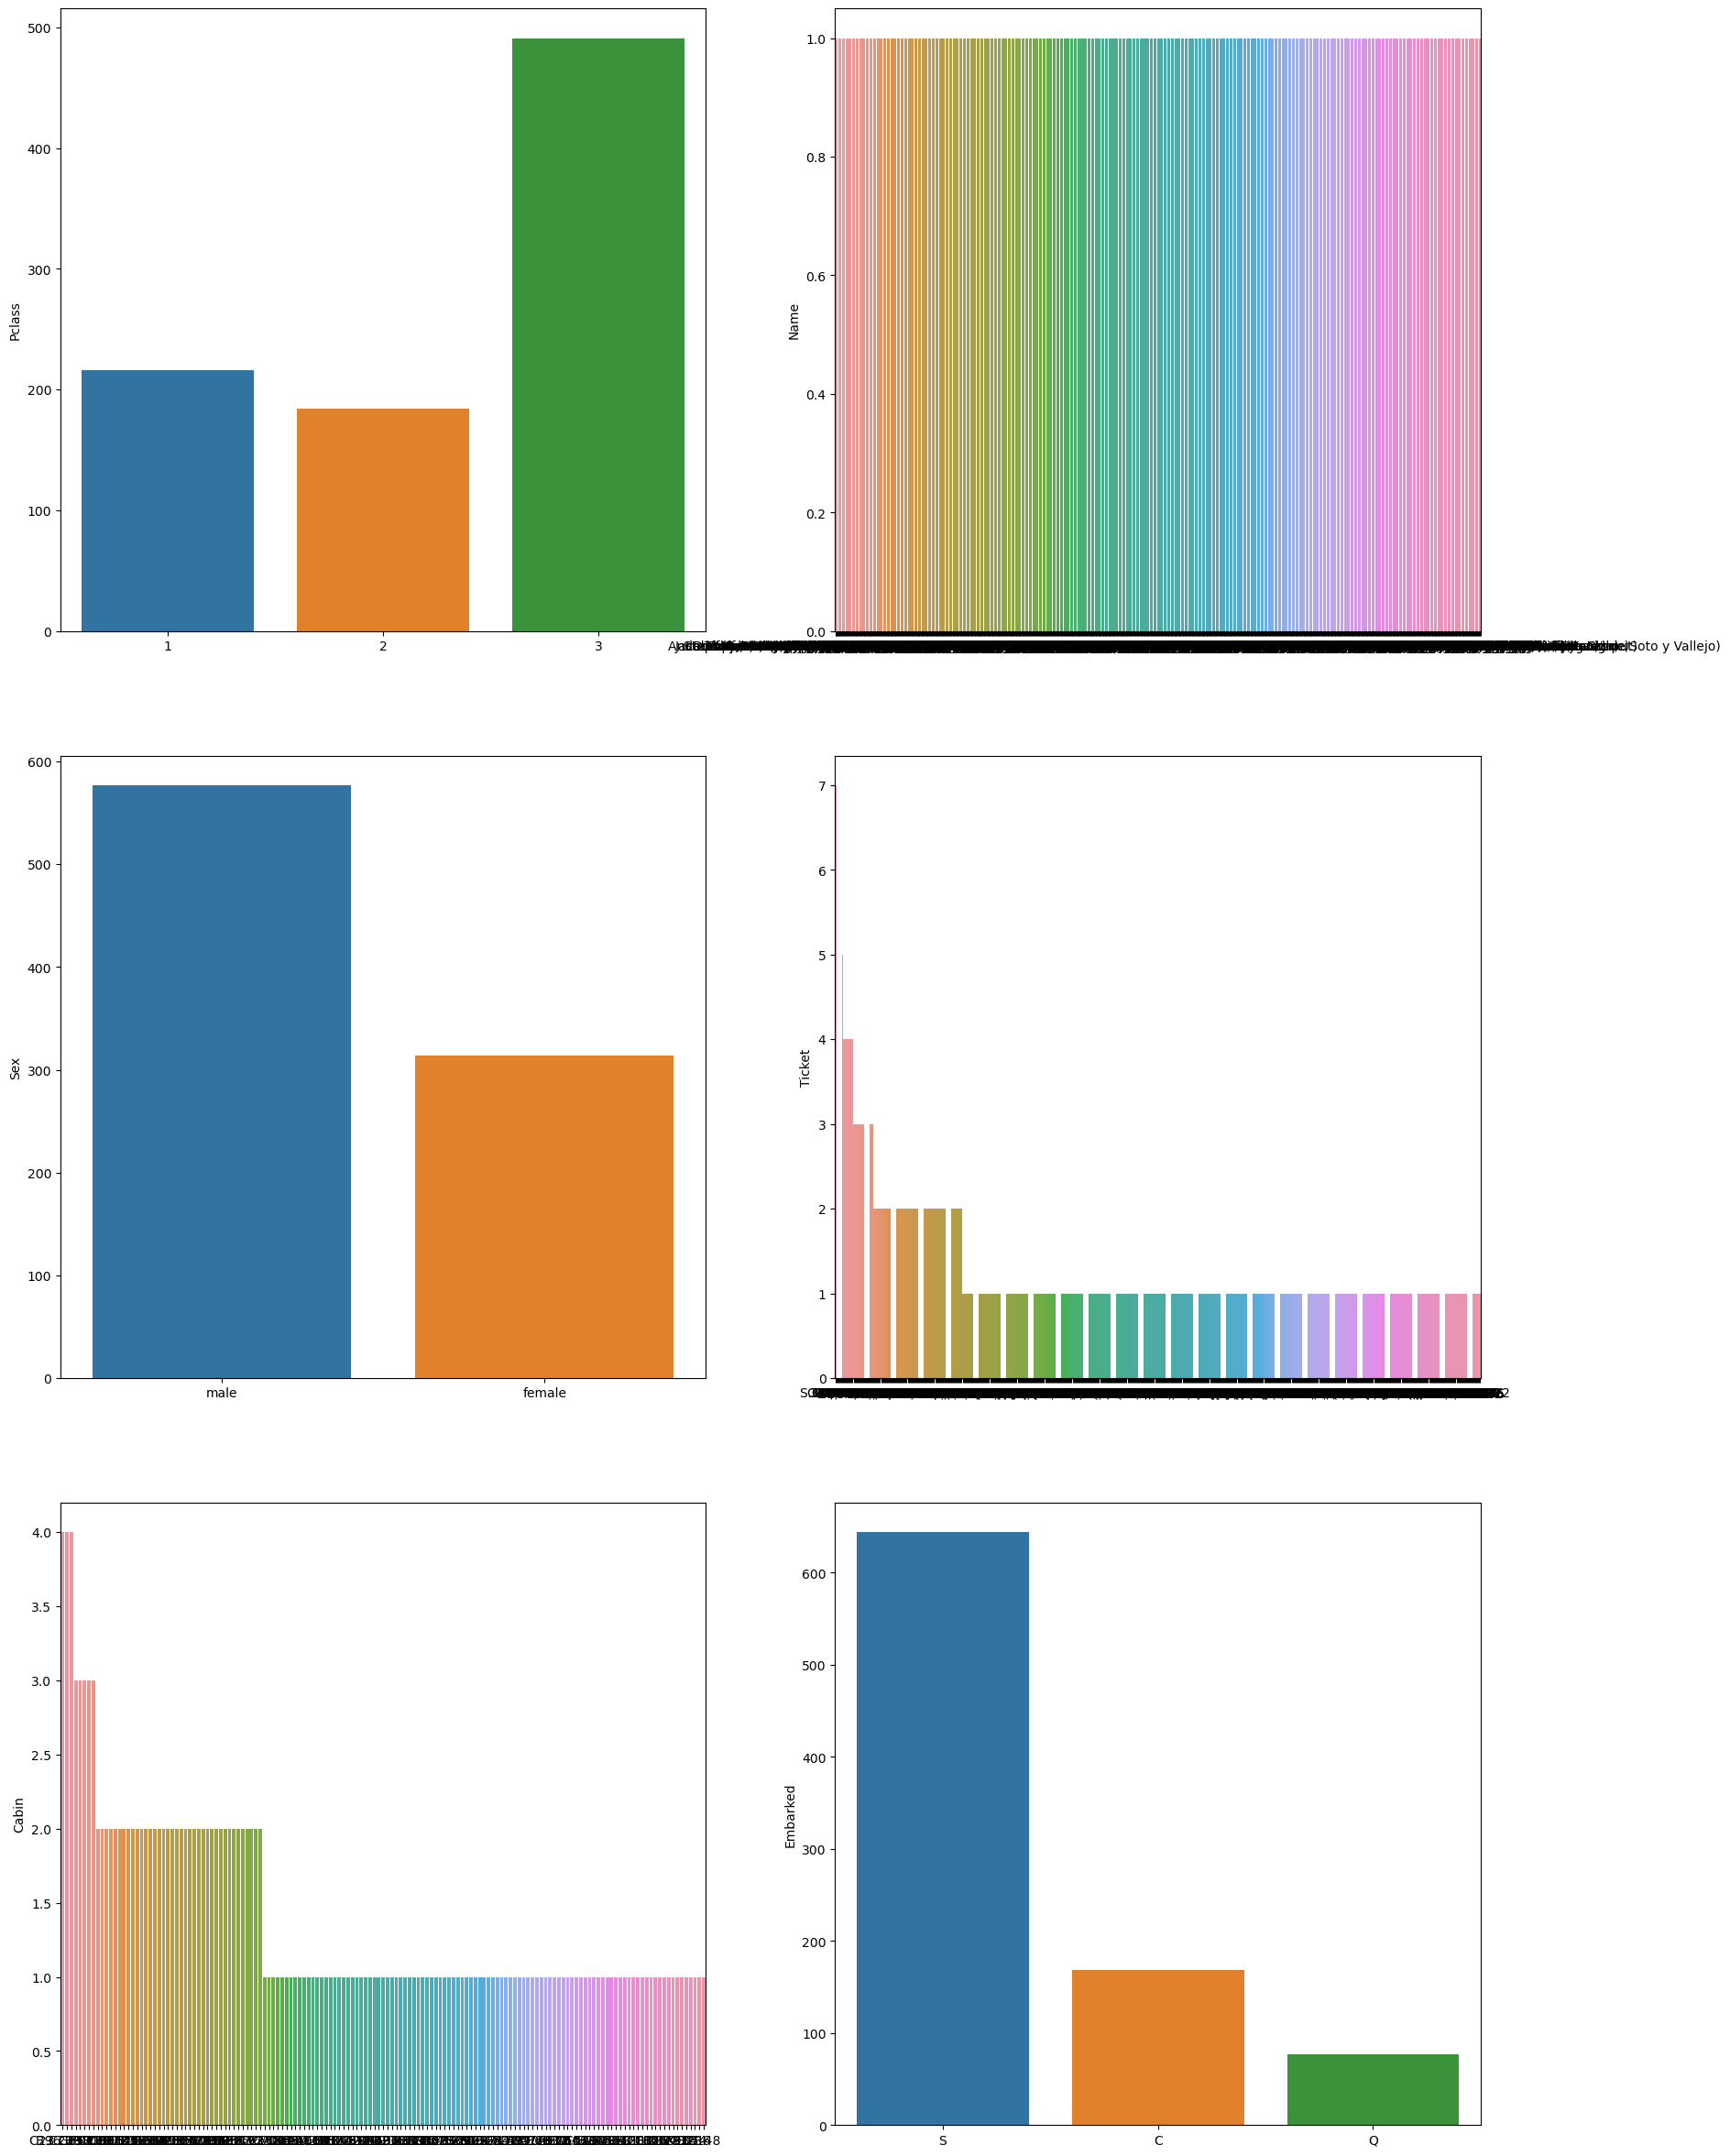

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(20, 30))#, sharey=True)
ax = axs.ravel()
for i, col in enumerate(categorical_cols):
#     train_data[col].value_counts().plot(kind='bar', ax=ax[i], title=col)
    sns.barplot(x=train_data[col].value_counts().index, y=train_data[col].value_counts(), ax=ax[i])

## Pivot Tables: Numerical Columns

In [13]:
eng_data.pivot_table(index='Survived', values=numerical_cols)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [14]:
print(train_data.pivot_table(index='SibSp', values='Survived'))
print()
print(train_data.pivot_table(index='Parch', values='Survived'))

       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000

       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000


## Pivot Tables: Categorical columns
There are passengers with multiple cabins.

In [15]:
# print(pd.pivot_table(train_data, index = 'Survived', columns = 'Sex', values = 'PassengerId', aggfunc ='count'))
# print()
# print(pd.pivot_table(train_data, index = 'Survived', columns = 'Pclass', values = 'PassengerId', aggfunc ='count'))
# print()
# print(pd.pivot_table(train_data, index = 'Survived', columns = 'Embarked', values = 'PassengerId', aggfunc ='count'))

In [16]:
print(train_data.pivot_table(index='Sex', values='Survived'))
print()
print(train_data.pivot_table(index='Pclass', values='Survived'))
print()
print(train_data.pivot_table(index='Embarked', values='Survived'))
# print()
# print(train_data.pivot_table(index='cabin_letter', values='Survived'))

        Survived
Sex             
female  0.742038
male    0.188908

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957


In [17]:
print(train_data.pivot_table(index='Sex', columns='Pclass', values='Survived'))
print()
print(train_data.pivot_table(index=['Embarked', 'Pclass'], values='Survived'))

Pclass         1         2         3
Sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

                 Survived
Embarked Pclass          
C        1       0.694118
         2       0.529412
         3       0.378788
Q        1       0.500000
         2       0.666667
         3       0.375000
S        1       0.582677
         2       0.463415
         3       0.189802


# Feature Engineering

## Ticket

Some tickets have lettering in addition to the numbers.

### Ticker Number

In [18]:
def ticket_num(df, column='Ticket', new_col='ticket_num'):
    df[new_col] = df[column].map(lambda t: t.split(' ')[-1])
    return df

eng_data = ticket_num(eng_data)

### Numeric Ticket: Boolean

In [19]:
def numeric_ticket(df, column='Ticket', new_col='numeric_ticket'):
    df[new_col] = df[column].map(lambda t: t.isnumeric())
    return df

eng_data = numeric_ticket(eng_data)
eng_data['numeric_ticket'].value_counts()

True     661
False    230
Name: numeric_ticket, dtype: int64

In [20]:
print(eng_data.pivot_table(index = 'Survived', columns = 'numeric_ticket', values = 'PassengerId', aggfunc ='count'))
print()
print('Percentage that survived:')
print(eng_data.pivot_table(index='numeric_ticket', values='Survived')) # Percentage that survived

numeric_ticket  False  True
Survived                   
0                 142   407
1                  88   254

Percentage that survived:
                Survived
numeric_ticket          
False           0.382609
True            0.384266


## Cabin

Data exploration of the Cabins shows that some passengers can have:
* Cabins without a letter.
* Cabins without a number.
* Multiple cabins.

The cabin number could also be looked at.

### Cabin Count

In [21]:
def cabin_count(df, column='Cabin', new_col='cabin_count'):
    df[new_col] = df[column].apply(lambda c: 0 if pd.isna(c) else len(c.split(' ')))
    return df

eng_data = cabin_count(eng_data)
eng_data['cabin_count'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_count, dtype: int64

In [22]:
print(eng_data.pivot_table(index = 'Survived', columns = 'cabin_count', values = 'PassengerId', aggfunc ='count'))
print()
print(eng_data.pivot_table(index = 'cabin_count', values = 'Survived'))

cabin_count      0      1    2    3    4
Survived                                
0            481.0   58.0  7.0  3.0  NaN
1            206.0  122.0  9.0  3.0  2.0

             Survived
cabin_count          
0            0.299854
1            0.677778
2            0.562500
3            0.500000
4            1.000000


### Cabin Letter

In [23]:
def cabin_letter(df, column='Cabin', new_col='cabin_letter'):
    
    def letter(cabin):
        if pd.isna(cabin):
            return 'none'
        elif len(cabin.split(' ')) == 1:
            if cabin.isalnum():
                return cabin[0]
            elif cabin.isalpha():
                return cabin
            elif cabin.isnum():
                return 'num'
        elif len(cabin.split(' ')) > 1:
            return 'mult'
        
    df[new_col] = df[column].apply(letter)
    return df

eng_data = cabin_letter(eng_data)
eng_data['cabin_letter'].value_counts()

none    687
C        51
B        36
E        32
D        32
mult     24
A        15
F         9
G         4
T         1
Name: cabin_letter, dtype: int64

In [24]:
print(eng_data.pivot_table(index = 'Survived', columns = 'cabin_letter', values = 'PassengerId', aggfunc ='count'))
print()
print(eng_data.pivot_table(index = 'cabin_letter', values = 'Survived'))

cabin_letter    A     B     C     D     E    F    G    T  mult   none
Survived                                                             
0             8.0   9.0  20.0   8.0   8.0  2.0  2.0  1.0  10.0  481.0
1             7.0  27.0  31.0  24.0  24.0  7.0  2.0  NaN  14.0  206.0

              Survived
cabin_letter          
A             0.466667
B             0.750000
C             0.607843
D             0.750000
E             0.750000
F             0.777778
G             0.500000
T             0.000000
mult          0.583333
none          0.299854


## Name Title

In [25]:
def name_title(df, name_column='Name', title_column='name_title'):
    df[title_column] = df[name_column].str.extract(r'(\w+\.)', expand=False)
    return df

eng_data = name_title(eng_data)
eng_data['name_title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: name_title, dtype: int64

In [26]:
print(eng_data.pivot_table(index = 'Survived', columns = 'name_title', values = 'PassengerId', aggfunc ='count'))
print()
print(eng_data.pivot_table(index = 'name_title', values = 'Survived'))

name_title  Capt.  Col.  Countess.  Don.  Dr.  Jonkheer.  Lady.  Major.  \
Survived                                                                  
0             1.0   1.0        NaN   1.0  4.0        1.0    NaN     1.0   
1             NaN   1.0        1.0   NaN  3.0        NaN    1.0     1.0   

name_title  Master.  Miss.  Mlle.  Mme.    Mr.  Mrs.  Ms.  Rev.  Sir.  
Survived                                                               
0              17.0   55.0    NaN   NaN  436.0  26.0  NaN   6.0   NaN  
1              23.0  127.0    2.0   1.0   81.0  99.0  1.0   NaN   1.0  

            Survived
name_title          
Capt.       0.000000
Col.        0.500000
Countess.   1.000000
Don.        0.000000
Dr.         0.428571
Jonkheer.   0.000000
Lady.       1.000000
Major.      0.500000
Master.     0.575000
Miss.       0.697802
Mlle.       1.000000
Mme.        1.000000
Mr.         0.156673
Mrs.        0.792000
Ms.         1.000000
Rev.        0.000000
Sir.        1.000000


## Feature crossing: SibSp + Parch

In [27]:
def cross(df, columns=['SibSp', 'Parch'], new_col='cross'):
    df[new_col] = df[columns[0]] + df[columns[1]]
    return df

eng_data = cross(eng_data) 
eng_data['cross'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: cross, dtype: int64

In [28]:
print(eng_data.pivot_table(index='cross', values='Survived'))
print()
print(eng_data.pivot_table(index='SibSp', values='Survived'))
print()
print(eng_data.pivot_table(index='Parch', values='Survived'))

       Survived
cross          
0      0.303538
1      0.552795
2      0.578431
3      0.724138
4      0.200000
5      0.136364
6      0.333333
7      0.000000
10     0.000000

       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000

       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000


# Feature Selection

## Correlation

In [29]:
corr = eng_data[numerical_cols + ['cross', 'Pclass', 'Survived']].corr(method='pearson')
corr

,Age,SibSp,Parch,Fare,cross,Pclass,Survived
Age,1.000000,-0.308247,-0.189119,0.096067,-0.301914,-0.369226,-0.077221
SibSp,-0.308247,1.000000,0.414838,0.159651,0.890712,0.083081,-0.035322
Parch,-0.189119,0.414838,1.000000,0.216225,0.783111,0.018443,0.081629
Fare,0.096067,0.159651,0.216225,1.000000,0.217138,-0.549500,0.257307
cross,-0.301914,0.890712,0.783111,0.217138,1.000000,0.065997,0.016639
Pclass,-0.369226,0.083081,0.018443,-0.549500,0.065997,1.000000,-0.338481
Survived,-0.077221,-0.035322,0.081629,0.257307,0.016639,-0.338481,1.000000


<AxesSubplot:>

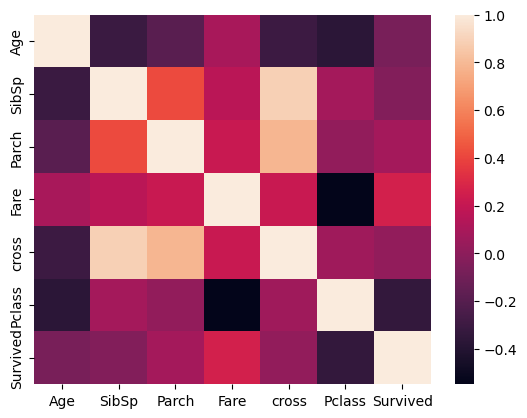

In [30]:
sns.heatmap(corr)

## Mutual Information
* from sklearn.feature_selection import mutual_info_classif
* Encoding with pd.get_dummies(), OneHotEncoding; s, _ = df[col].factorize(), or LabelEncoding

In [31]:
from sklearn.feature_selection import mutual_info_classif

# Preprocessing

## Preprocessing Pipeline

In [32]:
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Pclass', 'Sex', 'Embarked']
eng_cols = ['Ticket', 'Cabin', 'Name']#, 'cross']

In [33]:
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline([('feature_selection', SelectKBest(chi2, k=10)),
#     ('dimensionality_reduction', PCA(n_components=2))])

In [34]:
# Preprocessing Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
# from sklearn.base import BaseEstimator, TransformerMixin

num_transformer = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())

cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                       OneHotEncoder(handle_unknown='ignore'))#'infrequent_if_exist'

In [35]:
# numeric_ticket, name_title, cabin_letter, cross
ticket_transformer = make_pipeline(FunctionTransformer(lambda x: x.apply(lambda s: s.str.isnumeric())),
                                  OneHotEncoder())

title_transformer = make_pipeline(FunctionTransformer(lambda x: x.iloc[:,0].str.extract(r'(\w+\.)')),
                                  OneHotEncoder(handle_unknown='ignore'))
    
def letter(cabin):
    if pd.isna(cabin):
        return 'none'
    elif len(cabin.split(' ')) == 1:
        if cabin.isalnum():
            return cabin[0]
        elif cabin.isalpha():
            return cabin
        elif cabin.isnum():
            return 'num'
    elif len(cabin.split(' ')) > 1:
        return 'mult'

cabin_transformer = make_pipeline(FunctionTransformer(lambda x: x.iloc[:,0].apply(letter).values.reshape(-1,1)),
                                 OneHotEncoder(handle_unknown='ignore'))

In [36]:
from sklearn.compose import make_column_transformer

# When enclosing the column(s) in a list, 
# the input to the function in the FunctionTransformer is a dataframe.
# Otherwise it is a series
preprocessor = make_column_transformer((num_transformer, num_cols),
                                       (cat_transformer, cat_cols),
                                       (ticket_transformer, ['Ticket']),
                                       (cabin_transformer, ['Cabin']),
                                       (title_transformer, ['Name']))

In [37]:
def model_pipeline(model, preprocessor_=preprocessor):
    return make_pipeline(preprocessor, model)

## Cross-Validation Score

In [38]:
# This is a small dataset so it is advantageous to use cross validation.
def cv_score(pipeline, X, y, cv=5, scoring=['f1', 'roc_auc', 'balanced_accuracy',  'accuracy'][0]):
    scores = 1 * cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    return scores.mean()

## Test Set Evaluation Scores

In [39]:
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score

def evaluate(model, X, y, metric='f1'):
    if metric == 'f1':
        return f1_score(y, model.predict(X))
    elif metric == 'roc_auc':
        y_pred_proba = model.predict_proba(X)[:, 1]
        return roc_auc_score(y, y_pred_proba)
    elif metric =='accuracy':
        return model.score(X, y)
    elif metric == 'balanced_accuracy':
        return balanced_accuracy_score(y, model.predict(X))

## Hyperparameter Tuning: Grid Search

In [40]:
from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV #, HalvingGridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV

In [41]:
# When using GridSearchCV with Pipelines, use model_name__parameter_name

# Add the model name to the parameters
def grid_pipe_params(params, model_name):
    return {model_name + '__' + key: value for key, value in params.items()}

# Remove model_name__ from keys
def remove_model_name(params):
    return {key.split('__')[1]: value for key, value in params.items()}

In [42]:
# Find the optimum model hyperparameters

# def grid_search(model, params, X, y):
#     search = HalvingRandomSearchCV(
#         estimator=model,
#         param_distributions=params,
# #         n_iter=10,  # number of parameter settings that are sampled
#         scoring=['neg_mean_absolute_error', 'f1', 'accuracy'][2],#'accuracy',
#         cv=5,  # number of folds
#         n_jobs=-1,  # use all available cores
#         random_state=42,
#         refit=True
#         ).fit(X,y)
#     return search

def grid_search(model, params, X, y):
    search = GridSearchCV(
        model, 
        params, 
        cv=5, 
        scoring= ['f1', 'roc_auc', 'balanced_accuracy',  'accuracy'][0],
        n_jobs=-1).fit(X, y)
    return search

In [43]:
# Combine the grid search related functions defined above
def grid_search_hyperparameters(params, model, X, y, model_name=False):
    model_name = model_name if model_name else model.steps[-1][0]
    params = grid_pipe_params(params, model_name)
    search = grid_search(model, params, X, y)
    return search

def results(best_model) :
    hp = remove_model_name(best_model.best_params_)
    cross_val = best_model.best_score_
    print(f'Best params:{hp}')
    print(f'Best cross-val score: {cross_val}')
    return hp, cross_val

# Train & Test Sets

In [44]:
exclude = ['Survived', 'PassengerId']
X = train_data.drop(exclude, axis='columns', inplace=False)
y = train_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = model_pipeline(lr)

lr_cv = cv_score(lr, X_train, y_train)
lr_cv

0.7619887955182072

In [46]:
lr.fit(X_train, y_train)
lr_score = evaluate(lr, X_test, y_test)
lr_score

0.7919463087248321

## SVM
Support Vector Machine

In [47]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm = model_pipeline(svm)
svm_cv = cv_score(svm, X_train, y_train)
svm_cv

0.7666695772238622

In [48]:
svm.fit(X_train, y_train)
svm_score = evaluate(svm, X_test, y_test)
svm_score

0.7571428571428571

## KNN
k Nearest Neighbors

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
knn_param_grid = {
    'n_neighbors': list(range(4, 11))
}

knn = KNeighborsClassifier(n_jobs=-1)
knn = model_pipeline(knn)
knn_search = grid_search_hyperparameters(knn_param_grid, knn, X_train, y_train)
knn_params, knn_cv = results(knn_search)

Best params:{'n_neighbors': 5}
Best cross-val score: 0.7515666670717037


In [51]:
# knn = KNeighborsClassifier(**knn_params, n_jobs=-1)
# knn = model_pipeline(knn)
# knn.fit(X_train, y_train)

knn_best = knn_search.best_estimator_
knn_score = evaluate(knn_best, X_test, y_test)
knn_score

0.7659574468085106

## Decision Tree

In [52]:
from sklearn.tree import DecisionTreeClassifier

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 11)),
    'min_samples_split': list(range(2, 5)),
    'min_samples_leaf': list(range(1,3)),
    'max_leaf_nodes': [None] + list(range(2, 11)) 
}

dt = DecisionTreeClassifier(random_state=43)
dt = model_pipeline(dt)
dt_search = grid_search_hyperparameters(dt_param_grid, dt, X_train, y_train)
dt_params, dt_cv = results(dt_search)

Best params:{'criterion': 'entropy', 'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-val score: 0.7573958805915979


In [53]:
# dt = DecisionTreeClassifier(**dt_params, random_state=42)
# dt = model_pipeline(dt)
# dt.fit(X_train, y_train)

dt_best = dt_search.best_estimator_
dt_score = evaluate(dt_best, X_test, y_test)
dt_score

0.7746478873239436

## Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
#     'max_features': [],
#     'class_weight': ['None', 'balanced', 'balanced_subsample'],
    'n_estimators': list(range(100-50, 151, 50)),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 5)),
    'min_samples_split': list(range(2, 5)),
    'min_samples_leaf': list(range(1,3)),
}

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf = model_pipeline(rf)
rf_search = grid_search_hyperparameters(rf_param_grid, rf, X_train, y_train)
rf_params, rf_cv = results(rf_search)

Best params:{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-val score: 0.7629438820062437


In [55]:
# rf = RandomForestClassifier(**rf_params, n_jobs=-1, random_state=42)
# rf = model_pipeline(rf)
# rf.fit(X_train, y_train)

rf_best = rf_search.best_estimator_
rf_score = evaluate(rf_best, X_test, y_test)
rf_score

0.7916666666666666

## Gradient Boosting

In [56]:
from sklearn.ensemble import GradientBoostingClassifier

gb_param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 10, 20],
    'min_samples_split': list(range(2, 4)),
    'min_samples_leaf': list(range(1, 4)),
}

gb = GradientBoostingClassifier(random_state=42)
gb = model_pipeline(gb)
gb_search = grid_search_hyperparameters(gb_param_grid, gb, X_train, y_train)
gb_params, gb_cv = results(gb_search)

Best params:{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}
Best cross-val score: 0.7447804674634692


In [57]:
# gb = GradientBoostingClassifier(**gb_params, random_state=42)
# gb = model_pipeline(gb)
# gb.fit(X_train, y_train)

gb_best = gb_search.best_estimator_
gb_score = evaluate(gb_best, X_test, y_test)
gb_score

0.7808219178082192

## Extreme Gradient Boosting

In [58]:
from xgboost import XGBClassifier

xgb_param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 50],
    'subsample': [0.55, 0.6, .65],
    'colsample_bytree': [0.75,0.8,0.85],
    'gamma': [0.5, 1, 2]
}

xgb = XGBClassifier(random_state=42)
xgb = model_pipeline(xgb)
xgb_search = grid_search_hyperparameters(xgb_param_grid, xgb, X_train, y_train)
xgb_params, xgb_cv = results(xgb_search)

Best params:{'colsample_bytree': 0.75, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.65}
Best cross-val score: 0.7717760903481092


In [59]:
# xgb = XGBClassifier(**xgb_params, random_state=42)
# xgb = model_pipeline(xgb)
# xgb.fit(X_train, y_train)

xgb_best = xgb_search.best_estimator_
xgb_score = evaluate(xgb_best, X_test, y_test)
xgb_score

0.7692307692307693

## Voting Classifier

In [60]:
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[
    ('lr', lr),
    ('svm', svm),
    ('knn', knn),
    ('dt', dt),
    ('rf', rf),
    ('gb', gb),
    ('xgb', xgb)
], voting='soft')

vc_cv = cv_score(vclf, X_train, y_train)
vc_cv

0.7459282513194575

In [61]:
vclf.fit(X_train, y_train)
vc_score = evaluate(vclf, X_test, y_test)
vc_score

0.7887323943661971

# Model Comparison
Comparing test set scores is what matters when selecting a model. The validation set or cross validation scores are used for hyperparameter tunning.

In [62]:
# Cross-validation accuracy scores
scores = {
    'lr': lr_cv,
    'svm': svm_cv,
    'knn': knn_cv,
    'dt': dt_cv,
    'rf': rf_cv,
    'gb': gb_cv,
    'xgb': xgb_cv,
    'vc': vc_cv
}
scores

{'lr': 0.7619887955182072,
 'svm': 0.7666695772238622,
 'knn': 0.7515666670717037,
 'dt': 0.7573958805915979,
 'rf': 0.7629438820062437,
 'gb': 0.7447804674634692,
 'xgb': 0.7717760903481092,
 'vc': 0.7459282513194575}

In [63]:
# Test set accuracy scores
eval_scores = {
    'lr': lr_score,
    'svm': svm_score,
    'knn': knn_score,
    'dt': dt_score,
    'rf': rf_score,
    'gb': gb_score,
    'xgb': xgb_score,
    'vc': vc_score
}
eval_scores

{'lr': 0.7919463087248321,
 'svm': 0.7571428571428571,
 'knn': 0.7659574468085106,
 'dt': 0.7746478873239436,
 'rf': 0.7916666666666666,
 'gb': 0.7808219178082192,
 'xgb': 0.7692307692307693,
 'vc': 0.7887323943661971}

In [64]:
max_score = max(eval_scores, key=eval_scores.get)
max_score

'lr'

Logistic Regression has the highest test set evaluation score. There is a minimal difference between the test set score and the cross validation score, this demonstrates that the model did not overfit the training data set.

# Chosen Model's Performance Metrics

In [65]:
model = lr

## Confusion Matrix

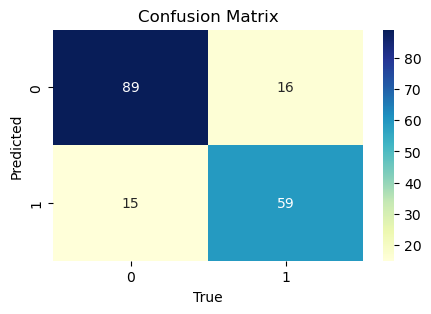

In [66]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model.predict(X_test))

fig = plt.figure(figsize=(5, 3))
ax = sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='d')
ax.set_title("Confusion Matrix")
ax.set_ylabel("Predicted")
ax.set_xlabel("True")
plt.show()

## Precision, Recall, F1-scores

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       105
           1       0.79      0.80      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



## Area Under the Reciever Operating Characteristic Curve: AUC-ROC

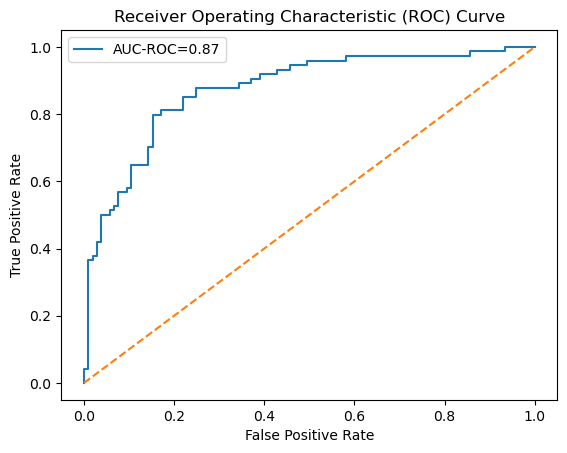

In [68]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'AUC-ROC={auc_roc:.2f}')
# roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
# sns.lineplot(x='fpr', y='tpr', data=roc_df, label=f'AUC-ROC={auc_roc:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Predictions

In [69]:
predictions = rf_best.predict(pred_data)

# Submission

**Submission of best results:**

In [70]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Possible ways to further improve the model: 
* Reducing the class imbalance: undersampling, oversampling or weighting.
* Regularization, e.g. Lasso (L1), Ridge (L2), ElasticNet.
* Try other models: 
    * Neural networks
* Encodings:
    * Try Label encoding with tree and ensemble models.
    * Try Ordinal encoding with Plass, Embarked.